In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import pickle
from torch.optim import lr_scheduler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

class CIFAR10Dataset(Dataset):
  def __init__(self, root, train, transform=None):
    self.root = root
    self.transform = transform
    self.train = train
    self.data = None
    self.labels = None

    if self.train:
      for i in range(1, 6):
        file = root + '/cifar-10-batches-py/data_batch_' + str(i)
        with open(file, 'rb') as temp:
          dict = pickle.load(temp, encoding='bytes')
        if self.data is not None:
          self.data = np.vstack((self.data, dict[b'data']))
        else:
          self.data = dict[b'data']

        if self.labels is not None:
          self.labels = np.vstack((self.labels,
                                   np.expand_dims(dict[b'labels'], axis=1)))
        else:
          self.labels = np.expand_dims(dict[b'labels'], axis=1)

    else:
      file = root + '/cifar-10-batches-py/test_batch'
      with open(file, 'rb') as temp:
        dict = pickle.load(temp, encoding='bytes')
        self.data = dict[b'data']
        self.labels = dict[b'labels']

    self.data = self.data.reshape(len(self.data), 3, 32, 32).transpose(0,2,3,1)
    self.labels = np.squeeze(self.labels)


  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data = self.data[index]
    label = self.labels[index]
    if self.transform:
      data = self.transform(data)

    return data, label

In [ ]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


class Trainer:
  def __init__(self, model, trainloader, testloader, loss_fn, optimizer, scheduler=None):
    self.model = model
    self.trainloader = trainloader
    self.testloader = testloader
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.scheduler = scheduler

  def train(self, epochs, device,  print_loss=False, print_interval=1, save=False):
    self.model = self.model.to(device)
    itr_loss_train = []
    itr_loss_test = []
    for epoch in tqdm(range(epochs)):
      self.model.train()
      train_loss = 0
      for batch_number, (X, y) in enumerate(self.trainloader):
        X, y = X.to(device), y.to(device)


        out_raw = self.model(X)
        out_preds = torch.softmax(out_raw, dim=1).argmax(dim=1)

        loss = self.loss_fn(out_raw, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        train_loss += loss
        if batch_number % 100 == 0:
          itr_loss_train.append(loss)

      train_loss /= len(self.trainloader)
      if self.scheduler:
        scheduler.step()

      self.model.eval()
      with torch.inference_mode():
        test_loss = 0
        test_acc= 0

        for batch_number, (X, y) in enumerate(self.testloader):
          X, y = X.to(device), y.to(device)

          out_raw = self.model(X)
          out_preds = torch.softmax(out_raw, dim=1).argmax(dim=1)


          loss = self.loss_fn(out_raw, y)
          test_loss += loss
          test_acc += torch.sum(out_preds == y)/len(y)
          if batch_number % 20 == 0:
            itr_loss_test.append(loss)

        test_loss /= len(self.testloader)
        test_acc /= len(self.testloader)


      if epoch % print_interval == 0 and print_loss:
        print(f'Train loss = {train_loss} | Test loss = {test_loss} | Test accuracy = {test_acc}')
    return itr_loss_train, itr_loss_test



In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

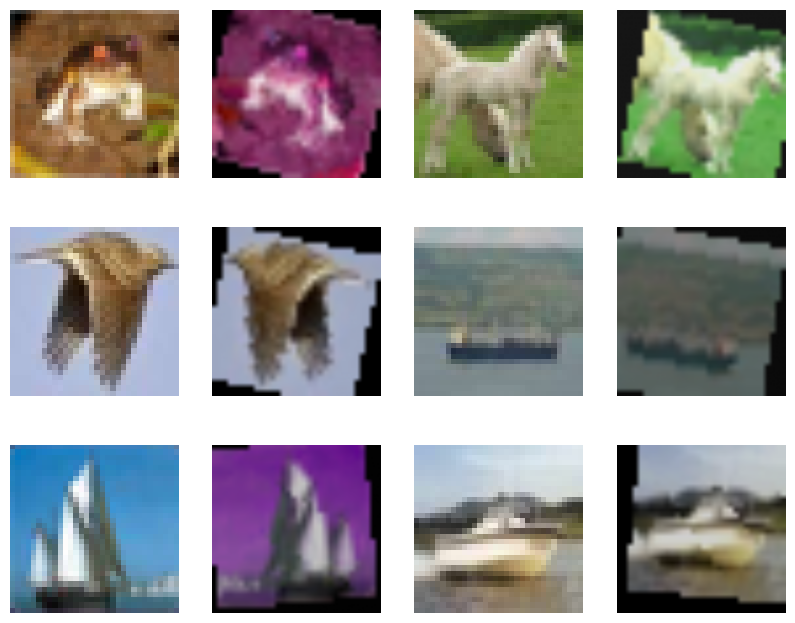

In [ ]:
transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-15, 15), translate=(0.08,0.08), scale=(0.9, 1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.ToPILImage()
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.ToPILImage()
    ])
tempset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        )


trainset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                       train=False,
                                       download=False,
                                       transform=transform_test)

fig = plt.figure(figsize=(10, 8))

for i in range(3):
  for j in range(2):
    fig.add_subplot(3, 4, (i*4)+(j*2)+1)
    plt.imshow(tempset[i*123 + j *469][0])
    plt.axis('off')
    fig.add_subplot(3, 4, (i*4)+(j*2)+2)
    plt.imshow(trainset[i*123 + j *469][0])
    plt.axis('off')



  0%|          | 0/10 [00:00<?, ?it/s]

Train loss = 1.5506818294525146 | Test loss = 1.2559096813201904 | Test accuracy = 0.5614052414894104
Train loss = 1.0473737716674805 | Test loss = 0.8848631381988525 | Test accuracy = 0.6910828351974487
Train loss = 0.8142735362052917 | Test loss = 0.8766571879386902 | Test accuracy = 0.705712616443634
Train loss = 0.6575788855552673 | Test loss = 0.7274441123008728 | Test accuracy = 0.7602508068084717
Train loss = 0.5344899296760559 | Test loss = 0.7394450306892395 | Test accuracy = 0.7573646903038025
Train loss = 0.43685635924339294 | Test loss = 0.6034539341926575 | Test accuracy = 0.7995620965957642
Train loss = 0.33831271529197693 | Test loss = 0.6217333674430847 | Test accuracy = 0.8055334687232971
Train loss = 0.2591800093650818 | Test loss = 0.7282599806785583 | Test accuracy = 0.8016520738601685
Train loss = 0.20214025676250458 | Test loss = 0.7137216925621033 | Test accuracy = 0.805931568145752
Train loss = 0.14749062061309814 | Test loss = 0.7921112179756165 | Test accuracy

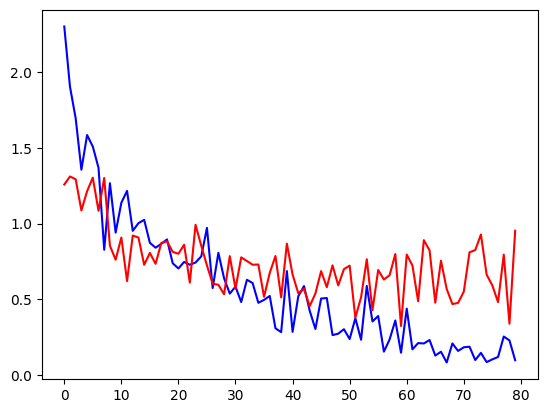

In [ ]:
# AlexNet
# No Augmentation
# No schedueler, SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = CIFAR10Dataset(root='drive/MyDrive/cifar-10',
                          train=True,
                          transform=transform_train)
testset = CIFAR10Dataset(root='drive/MyDrive/cifar-10',
                         train=False,
                         transform=transform_test)

BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = AlexNet(NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.9)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')
plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss = 1.8534055948257446 | Test loss = 1.664894700050354 | Test accuracy = 0.40893709659576416
Train loss = 1.458231806755066 | Test loss = 1.155935525894165 | Test accuracy = 0.5833997130393982
Train loss = 1.2165212631225586 | Test loss = 0.9981877207756042 | Test accuracy = 0.6581409573554993
Train loss = 1.044499158859253 | Test loss = 0.8773661255836487 | Test accuracy = 0.6875995397567749
Train loss = 0.944373607635498 | Test loss = 0.8507431149482727 | Test accuracy = 0.7093949317932129
Train loss = 0.8540215492248535 | Test loss = 0.778253436088562 | Test accuracy = 0.740346372127533
Train loss = 0.790318489074707 | Test loss = 0.6543273329734802 | Test accuracy = 0.7847332954406738
Train loss = 0.7413928508758545 | Test loss = 0.6492871642112732 | Test accuracy = 0.784136176109314
Train loss = 0.6983756422996521 | Test loss = 0.5855798721313477 | Test accuracy = 0.8062301278114319
Train loss = 0.6600944399833679 | Test loss = 0.570457398891449 | Test accuracy = 0.814589

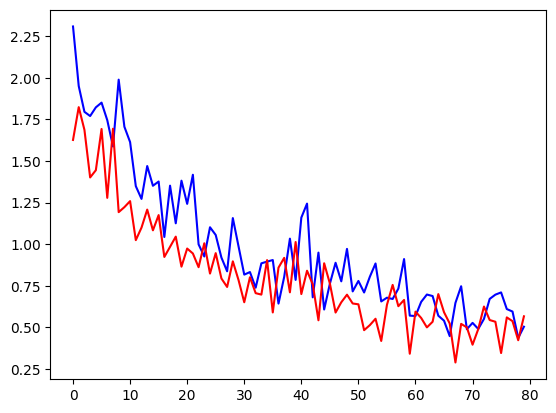

In [ ]:
# AlexNet
# with Augmentation
# No schedueler, SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-15, 15), translate=(0.08,0.08), scale=(0.9, 1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                       train=False,
                                       download=False,
                                       transform=transform_test)


BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = AlexNet(NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.9)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')
plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss = 1.5722318887710571 | Test loss = 1.39603853225708 | Test accuracy = 0.5278662443161011
Train loss = 1.1566647291183472 | Test loss = 0.9160142540931702 | Test accuracy = 0.6741639971733093
Train loss = 0.98135906457901 | Test loss = 0.8140251636505127 | Test accuracy = 0.7138734459877014
Train loss = 0.8591593503952026 | Test loss = 0.7361376285552979 | Test accuracy = 0.7474124431610107
Train loss = 0.7746026515960693 | Test loss = 0.6609296798706055 | Test accuracy = 0.765625
Train loss = 0.6982895731925964 | Test loss = 0.5877388715744019 | Test accuracy = 0.7952826619148254
Train loss = 0.6341755390167236 | Test loss = 0.533011794090271 | Test accuracy = 0.8178741931915283
Train loss = 0.5825982689857483 | Test loss = 0.5030884742736816 | Test accuracy = 0.8256369829177856
Train loss = 0.5316735506057739 | Test loss = 0.47436097264289856 | Test accuracy = 0.8374801278114319
Train loss = 0.4855402112007141 | Test loss = 0.4556504786014557 | Test accuracy = 0.84544187784

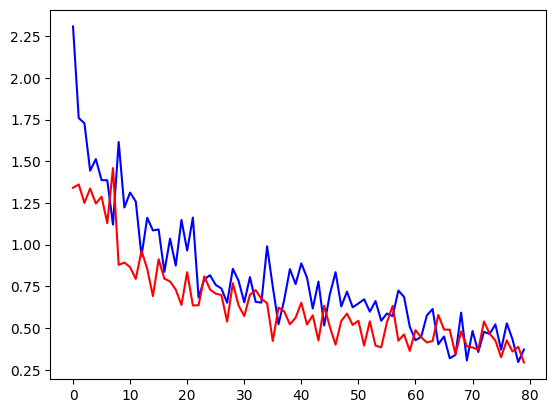

In [ ]:
# AlexNet
# With Augmentation
# Schedueler : Linear, Optimizer : SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-15, 15), translate=(0.08,0.08), scale=(0.9, 1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                       train=False,
                                       download=False,
                                       transform=transform_test)


BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = AlexNet(NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer, scheduler)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')

plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss = 1.5722318887710571 | Test loss = 1.39603853225708 | Test accuracy = 0.5278662443161011
Train loss = 1.1549568176269531 | Test loss = 0.9426912069320679 | Test accuracy = 0.6644108295440674
Train loss = 0.98026043176651 | Test loss = 0.8281745910644531 | Test accuracy = 0.7111862897872925
Train loss = 0.8562685251235962 | Test loss = 0.7116982936859131 | Test accuracy = 0.7558718323707581
Train loss = 0.769278347492218 | Test loss = 0.6677332520484924 | Test accuracy = 0.7643312215805054
Train loss = 0.6916893124580383 | Test loss = 0.5899977684020996 | Test accuracy = 0.7950835824012756
Train loss = 0.6275234818458557 | Test loss = 0.5361571907997131 | Test accuracy = 0.8183718323707581
Train loss = 0.5730888247489929 | Test loss = 0.5044922828674316 | Test accuracy = 0.8283240795135498
Train loss = 0.5202284455299377 | Test loss = 0.4757258892059326 | Test accuracy = 0.8388734459877014
Train loss = 0.47362422943115234 | Test loss = 0.4504719078540802 | Test accuracy = 0.8

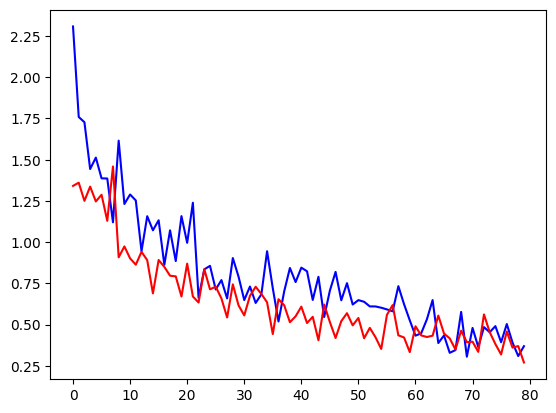

In [ ]:
# AlexNet
# With Augmentation
# Schedueler : Linear, Optimizer : SGD
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-15, 15), translate=(0.08,0.08), scale=(0.9, 1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                       train=False,
                                       download=False,
                                       transform=transform_test)


BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = AlexNet(NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer, scheduler)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')

plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss = 1.5722318887710571 | Test loss = 1.39603853225708 | Test accuracy = 0.5278662443161011
Train loss = 1.1262704133987427 | Test loss = 0.9215061664581299 | Test accuracy = 0.6664012670516968
Train loss = 0.9377400875091553 | Test loss = 0.7727636694908142 | Test accuracy = 0.7265127301216125
Train loss = 0.8123801350593567 | Test loss = 0.6765767335891724 | Test accuracy = 0.7628383636474609
Train loss = 0.7275095582008362 | Test loss = 0.6433202028274536 | Test accuracy = 0.7763734459877014
Train loss = 0.6590737700462341 | Test loss = 0.5573761463165283 | Test accuracy = 0.8066281676292419
Train loss = 0.6101365089416504 | Test loss = 0.5309371948242188 | Test accuracy = 0.818869411945343
Train loss = 0.5753917694091797 | Test loss = 0.5292133688926697 | Test accuracy = 0.8170780539512634
Train loss = 0.5459983944892883 | Test loss = 0.49660906195640564 | Test accuracy = 0.8308120965957642
Train loss = 0.5265130996704102 | Test loss = 0.4921458661556244 | Test accuracy = 0

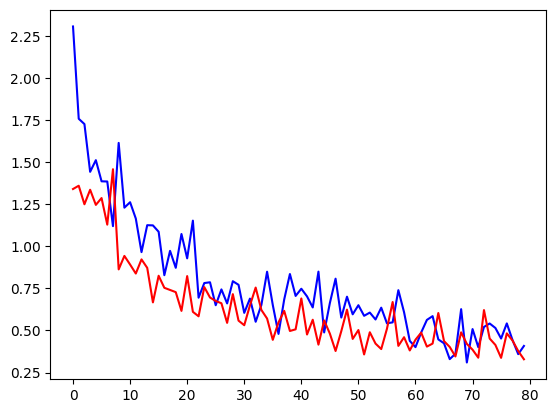

In [ ]:
# AlexNet
# With Augmentation
# Schedueler : Exponential, Optimizer : SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-15, 15), translate=(0.08,0.08), scale=(0.9, 1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((227,227)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                       train=False,
                                       download=False,
                                       transform=transform_test)


BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = AlexNet(NUM_CLASSES).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer, scheduler)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')

plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train loss = 1.839384913444519 | Test loss = 1.6296199560165405 | Test accuracy = 0.39530256390571594
Train loss = 1.3019908666610718 | Test loss = 1.2322332859039307 | Test accuracy = 0.5821058750152588
Train loss = 1.0144808292388916 | Test loss = 1.022676706314087 | Test accuracy = 0.646795392036438
Train loss = 0.7978349924087524 | Test loss = 0.9228002429008484 | Test accuracy = 0.6888933181762695
Train loss = 0.641377866268158 | Test loss = 0.7235007882118225 | Test accuracy = 0.7514928579330444
Train loss = 0.5308889746665955 | Test loss = 0.7643877267837524 | Test accuracy = 0.7389530539512634
Train loss = 0.433011919260025 | Test loss = 0.6669766306877136 | Test accuracy = 0.7869227528572083
Train loss = 0.3484271168708801 | Test loss = 0.6440060138702393 | Test accuracy = 0.7875199317932129
Train loss = 0.2688455879688263 | Test loss = 0.7453910112380981 | Test accuracy = 0.787619411945343
Train loss = 0.22030095756053925 | Test loss = 0.7109329104423523 | Test accuracy = 0.8

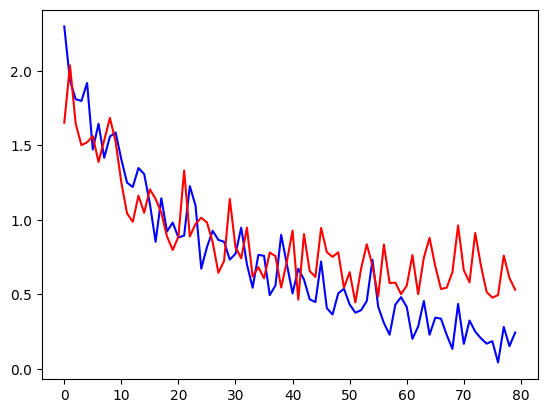

In [ ]:
# ResNet
# No Augmentation
# No schedueler, SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = CIFAR10Dataset(root='drive/MyDrive/cifar-10',
                          train=True,
                          transform=transform_train)
testset = CIFAR10Dataset(root='drive/MyDrive/cifar-10',
                         train=False,
                         transform=transform_test)

BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum = 0.9)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')
plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train loss = 1.776561975479126 | Test loss = 1.62065589427948 | Test accuracy = 0.45352309942245483
Train loss = 1.1680127382278442 | Test loss = 1.0176963806152344 | Test accuracy = 0.6603304147720337
Train loss = 0.9052734375 | Test loss = 1.0733174085617065 | Test accuracy = 0.6614251732826233
Train loss = 0.7846270799636841 | Test loss = 0.7254066467285156 | Test accuracy = 0.7577627301216125
Train loss = 0.6830766797065735 | Test loss = 0.5493844151496887 | Test accuracy = 0.8140923976898193
Train loss = 0.6122126579284668 | Test loss = 0.5245471000671387 | Test accuracy = 0.8230493664741516
Train loss = 0.5584441423416138 | Test loss = 0.4910900294780731 | Test accuracy = 0.8323049545288086
Train loss = 0.5113050937652588 | Test loss = 0.43174073100090027 | Test accuracy = 0.8543989062309265
Train loss = 0.45878568291664124 | Test loss = 0.42735353112220764 | Test accuracy = 0.8558917045593262
Train loss = 0.40977463126182556 | Test loss = 0.38422873616218567 | Test accuracy = 0.

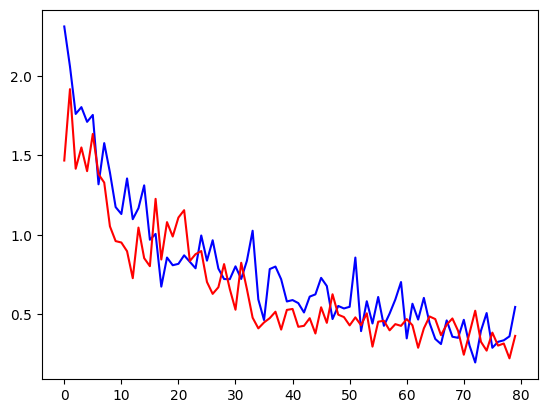

In [ ]:
# ResNet
# With Augmentation
# Schedueler : Linear, Optimizer : SGD
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-15, 15), translate=(0.08,0.08), scale=(0.9, 1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                       train=False,
                                       download=False,
                                       transform=transform_test)


BATCH_SIZE = 64
EPOCHS = 10
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer, scheduler)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')

plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss = 1.761878252029419 | Test loss = 1.3084179162979126 | Test accuracy = 0.5183120965957642
Train loss = 1.1492849588394165 | Test loss = 1.0029716491699219 | Test accuracy = 0.6585389971733093
Train loss = 0.8982393741607666 | Test loss = 0.8636489510536194 | Test accuracy = 0.7080016136169434
Train loss = 0.7792572379112244 | Test loss = 0.74234938621521 | Test accuracy = 0.7503980994224548
Train loss = 0.6806778907775879 | Test loss = 0.5654194951057434 | Test accuracy = 0.8055334687232971
Train loss = 0.6118376851081848 | Test loss = 0.5367618799209595 | Test accuracy = 0.8203622698783875
Train loss = 0.5573798418045044 | Test loss = 0.468870609998703 | Test accuracy = 0.8407643437385559
Train loss = 0.5097223520278931 | Test loss = 0.46537184715270996 | Test accuracy = 0.8380772471427917
Train loss = 0.4613136947154999 | Test loss = 0.4275699257850647 | Test accuracy = 0.8563893437385559
Train loss = 0.41340023279190063 | Test loss = 0.3868279755115509 | Test accuracy = 0

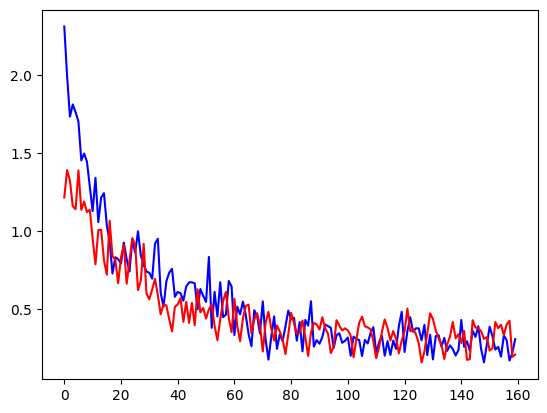

In [ ]:
# ResNet
# With Augmentation
# Schedueler : Linear, Optimizer : SGD
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(90)
torch.cuda.manual_seed(90)

transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=(-15, 15), translate=(0.08,0.08), scale=(0.9, 1)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, hue=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(
              mean=[0.4914, 0.4822, 0.4465],
              std=[0.2023, 0.1994, 0.2010],)
    ])

trainset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                        train=True,
                                        download=False,
                                        transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='drive/MyDrive/cifar-10',
                                       train=False,
                                       download=False,
                                       transform=transform_test)


BATCH_SIZE = 64
EPOCHS = 20
NUM_CLASSES = 10

trainloader = DataLoader(dataset=trainset,
                         batch_size = BATCH_SIZE,
                         shuffle=True)
testloader = DataLoader(dataset=testset,
                        batch_size=BATCH_SIZE,
                        shuffle=False)

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.1, total_iters=10)

trainer = Trainer(model, trainloader, testloader, loss_fn, optimizer, scheduler)
train_loss, test_loss = trainer.train(EPOCHS, device, print_loss=True, print_interval=1)

train_loss = torch.Tensor(train_loss).to('cpu')
test_loss = torch.Tensor(test_loss).to('cpu')

plt.plot(range(len(train_loss)), train_loss, label='Train loss', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test_loss', color='red')
